## Модули

In [2]:
import torch
from matplotlib import pyplot as plt
import pandas as pd

## Постановка задачи

В машинном обучении очень большую роль играет интерпретируемость модели, иными словами простота объяснения результата, полученного с помощью модели. Интерпретируемостью обладают далеко не все алгоритмы. Деревья решений, в отличие например, от случайного леса и градиентного бустинга, достаточно просто объясняются с помощью визуализации построенного дерева. Кроме того, интерпретируемостью обладают линейные модели и формульные, т.к. в этом виде достаточно легко вычислить, как изменится целевая переменная, если увеличить одну из фичей на единицу (в случае непрерывной фичи).

Формула для вычисления целевой переменной на основе фичей называется экспертной моделью. И один из вариантов её построение - это нахождение весов в формуле с помощью градиентного спуска. В сегодняшнем задании мы именно это и сделаем с применением фреймворка torch, в котором очень удобно воспользоваться различными оптимизаторами, о которых рассказывалось в лекции.

Для выполнения задания вам необходимо скачать ipython notebook и датасет с диска. Датасет содержит в себе почасовой тренд посещаемости сайта за 10 лет. Все високосные годы и аномалии из него предварительно вычищены. Аналитик предположил, что тренд может описываться формулой:

$trend=e^{A*days} + B$

## Подготовка данных

In [3]:
y_train = pd.read_csv('views.csv')

<AxesSubplot:>

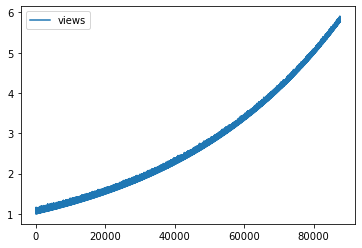

In [4]:
y_train.plot()

<AxesSubplot:>

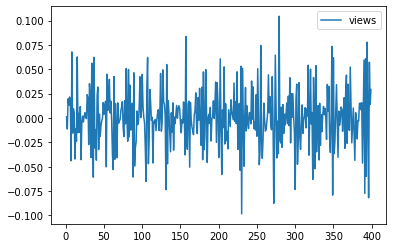

In [7]:
y_train.diff()[:400].plot()

In [8]:
# Для обучения моделей с torch необходимо, чтобы датасет был в формате torch.tensor
# Формат очень похож на np.array

y = torch.tensor(pd.read_csv('views.csv').views.to_numpy()).float()
X = (torch.tensor(pd.read_csv('views.csv').index.to_numpy()) + 1).float()

## Обучим модель

In [9]:
# Модель в pytorch задаётся с помощью объявления класса, обладающего методом forward

class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # С помощью задания атрибутов класса мы зададим веса в нашей модели
        # Для того, чтобы веса модели поддерживали градиентный спуск, мы зададим их с помощью torch.nn.Embedding
        
        # Этот вес соответствует коэффициенту перед количеством дней в экспоненте
        self.A_coeff = torch.nn.Embedding.from_pretrained(
            torch.zeros(1, 1),
            freeze=False
        )
        
        # Этот вес соответствует свободному члену уравнения
        self.B_coeff = torch.nn.Embedding.from_pretrained(
            torch.zeros(1, 1),
            freeze=False
        )

    # Внутри метода forward можно в явном виде задать функцию, которую мы будем использовать
    def forward(self, x):
        
        # Чтобы использовать значения коэффициентов, хранимые в эмбеддингах
        # Необходимо воспользоваться атрибутом Embedding.weight эмбеддинга
        exponent = torch.exp(self.A_coeff.weight * x)
        B = self.B_coeff.weight

        out = (
            exponent + B
        ).view(-1)
        return out.float()


In [21]:
torch.std(y)

tensor(1.3429)

In [19]:
# Инициализируем модель
model = MyModel()

# В качества функционала ошибки будем использовать MSE Loss
loss_fn = torch.nn.MSELoss()

# Вид градиентного спуска определяется выбранным оптимизатором
# Чтобы сменить оптимизатор,  замените Adam на любой, который считаете необходимым
# Например SGD, или AdaGrad, или RMSProp - все варианты вы найдёте в torch.optim
# Основной вклад в сходимость модели делает размер  lr и количество эпох
# Ваша задача - поймать оптимальный размер lr (его рекомендуется уменьшить)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-6)

# На точность итоговой модели влияет количество шагов,  которое выполняется при градиентом спуске
# Чтобы увеличить или уменьшить кол-во шагов,  измените значение n_epochs
n_epochs = 100

for epoch in range(n_epochs):
    # Стандартный процесс обучения с помощью torch выглядить следующим образом
    
    # На первом шаге нам необходимо рассчитать прогноз модели на основе матрица признаков Х
    y_pred = model(X)
    
    # На втором шаге мы вычисляем текущую ошибку прогноза с помощью выбранного нами функционала ошибки
    loss = loss_fn(y, y_pred)
    print(loss) # Для удобства наблюдения за уменьшением ошибки выведем его в консоль
    
    # На последнем шаге мы делаем шаг градиента, который считается на основе нашего выбранного lr 
    # Перед шагом градиента мы обнулим старый результат в оптимизаторе
    optimizer.zero_grad()
    # Затем рассчитаем градиент с помошью обратного распространения ошибки
    loss.backward() 
    # И выполним шаг градиентного спуск
    optimizer.step()


tensor(4.9861, grad_fn=<MseLossBackward0>)
tensor(4.2727, grad_fn=<MseLossBackward0>)
tensor(3.4697, grad_fn=<MseLossBackward0>)
tensor(2.5920, grad_fn=<MseLossBackward0>)
tensor(1.6797, grad_fn=<MseLossBackward0>)
tensor(0.8192, grad_fn=<MseLossBackward0>)
tensor(0.1775, grad_fn=<MseLossBackward0>)
tensor(0.0297, grad_fn=<MseLossBackward0>)
tensor(0.5577, grad_fn=<MseLossBackward0>)
tensor(1.1022, grad_fn=<MseLossBackward0>)
tensor(1.0368, grad_fn=<MseLossBackward0>)
tensor(0.6270, grad_fn=<MseLossBackward0>)
tensor(0.2366, grad_fn=<MseLossBackward0>)
tensor(0.0324, grad_fn=<MseLossBackward0>)
tensor(0.0133, grad_fn=<MseLossBackward0>)
tensor(0.1049, grad_fn=<MseLossBackward0>)
tensor(0.2297, grad_fn=<MseLossBackward0>)
tensor(0.3353, grad_fn=<MseLossBackward0>)
tensor(0.3952, grad_fn=<MseLossBackward0>)
tensor(0.4015, grad_fn=<MseLossBackward0>)
tensor(0.3584, grad_fn=<MseLossBackward0>)
tensor(0.2786, grad_fn=<MseLossBackward0>)
tensor(0.1808, grad_fn=<MseLossBackward0>)
tensor(0.08

In [22]:
# Посмотреть текущие коэффициенты модели можно с помощью метода state_dict модели
model.state_dict()

OrderedDict([('A_coeff.weight', tensor([[2.0175e-05]])),
             ('B_coeff.weight', tensor([[5.4838e-05]]))])

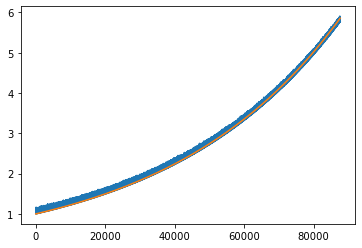

In [23]:
# Чтобы убедиться, что модель обучилась хорошо, можно воспользоваться графиком
plt.plot(y.detach().numpy())
plt.plot(model(X).detach().numpy())